# Multipulse measurement
This script is used to apply voltage pulses with varied pulsewidth and capture the device response at the oscilloscope

#### Import library files and list instruments connected to the resource manager

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyvisa
from datetime import datetime
from scr import *
import glob

rm = pyvisa.ResourceManager()
print(rm.list_resources()) # list connected instruments

('TCPIP0::192.168.0.5::inst0::INSTR', 'ASRL3::INSTR', 'ASRL4::INSTR', 'GPIB0::10::INSTR')


#### Open a connection with resource manager

In [2]:
pulsegen = rm.open_resource("GPIB0::10::INSTR")
scope = rm.open_resource("TCPIP0::192.168.0.5::inst0::INSTR")
print(pulsegen.query("*IDN?"))
print(scope.query("*IDN?"))

HEWLETT-PACKARD,HP81110A,DE38700131,REV 01.12.03

AGILENT TECHNOLOGIES,DSO-X 3034A,MY53160262,02.43.2018020635



#### Initialize the instruments

In [34]:
# ======== initialize pulse generator ====================

pulsegen.write("*RST")
pulsegen.write(":DISPlay On")
pulsegen.write(":HOLD VOLT") # enable voltage or current subsystem
pulsegen.write(":ROSC:SOUR Int")  # external reference clock
pulsegen.write(":OUTP1:IMP 50OHM")  # set OUT1 source impedance
pulsegen.write(":OUTP1:IMP:EXT 50OHM")  # or 1MOHM 
pulsegen.write(":OUTP1:POL NORM")   # set OUT1 polarity
pulsegen.write(":CHAN:MATH OFF")  # channel math off
pulsegen.write(":TRIG:COUN 1")
pulsegen.write(":ARM:SOUR MAN")
#pulsegen.write("*WAI")

# ======== initialize Oscilloscope =======================

scope.write("*CLS")
scope.write("*RST")

scope.write("CHAN1:DISP OFF")  # enable channel 1 trace
scope.write("CHAN1:COUP DC")  # channel 1 coupling
scope.write("CHAN1:BWL OFF") # set channel 1 bandwidth to full bandwidth of oscilloscope
scope.write("CHAN1:IMP FIFT") # or ONEMeg
scope.write("CHAN1:SCAL 1")  # set channel 1 vertical scale
scope.write("CHAN1:OFFS 0")  # set channel 1 offset

scope.write("CHAN2:DISP ON")  
scope.write("CHAN2:COUP DC")  
scope.write("CHAN2:BWL OFF") 
scope.write("CHAN2:IMP FIFT") #FIFT
scope.write("CHAN2:SCAL 1")  
scope.write("CHAN2:OFFS 0")  

scope.write(":TIMebase:SCALe 1")
scope.write(":TIMebase:POSition 0")

scope.write("TRIG:SOUR EXT") # Externally triggered from pulse generator
scope.write("TRIG:MODE EDGE") # Edge triggered
scope.write("TRIG:SLOP POS") # Triggered on positive slope


15

#### Define the functions for apply pulse, measure and aquire data

In [49]:
def apply_pulse(ep):
    pulsegen.write(f":VOLT1 {ep.amplitude}V")
    pulsegen.write(f":VOLT1:OFFS {ep.amplitude/2}V") # set offset = amplitude/2
    pulsegen.write(f":PULS:WIDT {ep.pulsewidth}NS")
    pulsegen.write(f":PULS:TRAN {ep.risetime}NS") # leading edge transition time
    pulsegen.write(f":PULS:TRAN:TRA:AUTO OFF") # trailing edge = leading edge OFF
    pulsegen.write(f":PULS:TRAN:TRA {ep.falltime}NS") # trailing edge transition time

# ===== Set Recording parameters at scope =======
def measure_scope(ep):
    Vout = ep.amplitude * (50/ (50 + Rs))
    if (ep.amplitude > 5):
        scope.write(f"CHAN2:SCAL {Vout / 4*2}")
        scope.write(f"CHAN2:OFFS {Vout / 2*2}")
    else:
        scope.write(f"CHAN2:SCAL {Vout / 4}")
        scope.write(f"CHAN2:OFFS {Vout / 2}")
    pulseLength = (ep.pulsewidth + ep.risetime + ep.falltime) * 1e-9
    scope.write(f"TIM:SCAL {pulseLength/4}")
    #scope.write(f"TIM:POS {0}")
    scope.write(f"TIM:POS {pulseLength}")
    scope.write(":ACQUIRE:TYPE HRES")
    scope.write(":SINGLE") # Acquire a single trigger of data

# ====== Trigger the pulse =====================
def trigger_pulse():
    pulsegen.write(":OUTP1 ON")  # Turn on OUT1
    sleep(0.5)
    pulsegen.write("*TRG")
    sleep(1)
    pulsegen.write(":OUTP1 OFF")  # Turn off OUT1


# ========= Aquire data =======================
def aquire_data():
    waveform = WaveForm()
    # store all this information into a waveform structure for later use
    #scope.write(f":WAVEFORM:SOURCE CHAN1")
    # Get the data back as a WORD(i.e., INT16), other options are ASCII and BYTE
    #scope.write(":WAVEFORM:FORMAT WORD")
    # Set the byte order on the instrument as well
    #scope.write(":WAVEFORM:BYTEORDER LSBFirst")
    # Get the preamble block
    #preambleBlock = scope.query(":WAVeform:PREamble?")
    #rawData = scope.query_binary_values(":WAV:DATA?", "H")
    #waveform.addChannel(1, preambleBlock.split(","), rawData)
    
    scope.write(f":WAVEFORM:SOURCE CHAN2")
    scope.write(":WAVEFORM:FORMAT WORD")
    scope.write(":WAVEFORM:BYTEORDER LSBFirst")
    preambleBlock = scope.query(":WAVeform:PREamble?")
    rawData = scope.query_binary_values(":WAV:DATA?", "H")
    waveform.addChannel(2, preambleBlock.split(","), rawData)
    
def execute(ep):
    apply_pulse(ep)
    measure_scope(ep)
    trigger_pulse()
    aquire_data()


### Set pulse parameters and execute the code

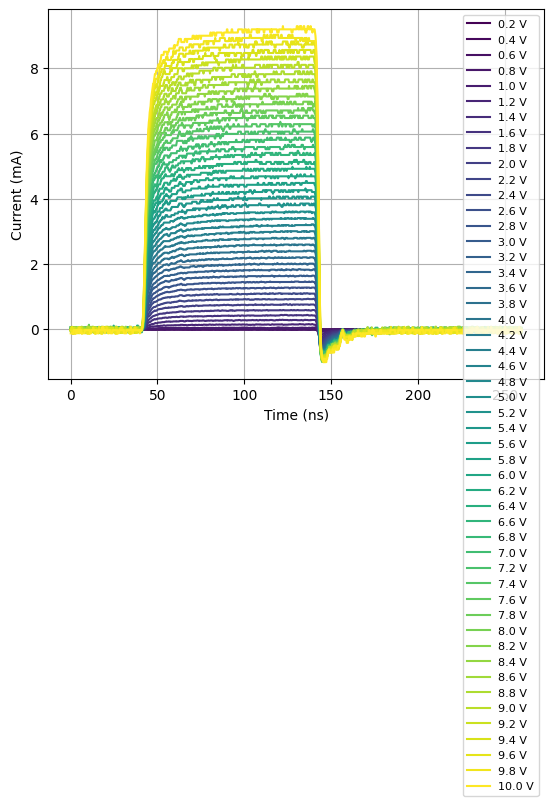

In [51]:
# Plot channel 2 voltages with respect to time
plt.figure()
plt.xlabel("Time (ns)")
plt.ylabel("Current (mA)")
plt.grid(which='both')
# ========= Set pulse parameters =============
Rs = 2000
n = 50
colors = plt.cm.viridis(np.linspace(0, 1, n)) # using color map for plot
for i in range (n):
    ep = PulseParameters(
        amplitude=0.2*(i+1),  # V
        pulsewidth=100,  # ns
        risetime=2,  # ns
        falltime=2,  # ns
    )
    execute(ep)
    waveform = WaveForm()
    plt.plot(waveform.time(2) * 1e9, waveform.ch(2)*1000/50, color=colors[i], label=str('{:.1f}'.format(ep.amplitude)+' V'))
    #sp = SampleParameters('d01_'+str('{:.0e}'.format(ep.pulsewidth)+'ns'))
    data_on_ch2 = pd.DataFrame(
    {
        "Time (s)"         : waveform.time(2),
        "Voltage (V)"      : waveform.ch(2),
    }
    )
    data_on_ch2.to_csv('d01_100ns'+str('{:.1f}'.format(0.2*(i+1))) + 'V.csv', index=False)

    #np.savez_compressed(f"{sp.name}", **waveform.asdict()) #save multiple arrays
    
#plt.legend(fontsize="8", loc="best")

#### Plot the measured data

[0.003974874623998, 0.004233668863998, 0.004992463103998, 0.010075372031998, 0.05585930751999999, 0.15742465152, 0.29084671871999995, 0.43824121344000005, 0.58935176448, 0.76779897856, 0.9336858739200001, 1.10409304448, 1.2772161279999998, 1.4620954803200001, 1.64325874048, 1.8418063577600001, 2.02829408128, 2.204633215999998, 2.4063969664, 2.59640442752, 2.8013846079999998, 3.005060416, 3.2156683776, 3.4088919103999995, 3.6074395583999976, 3.8534849139200005, 4.0667635967999995, 4.3170273472, 4.5420632, 4.7464978304, 4.9798763328, 5.191547110399999, 5.470755551999999, 5.652678464000001, 5.874801516799998, 6.129890303999999, 6.3597495552000005, 6.5489067712, 6.783894131199999, 6.975465376, 7.216080895999999, 7.4599124928, 7.6563058048, 7.9057655104, 8.193015219199998, 8.3601608704, 8.561380448, 8.8220964736, 9.0257258816, 9.292070016]
[0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.2000000000000002, 1.4000000000000001, 1.6, 1.8, 2.0, 2.2, 2.4000000000000004, 2.6, 2.8000000000000003, 3.0, 3.

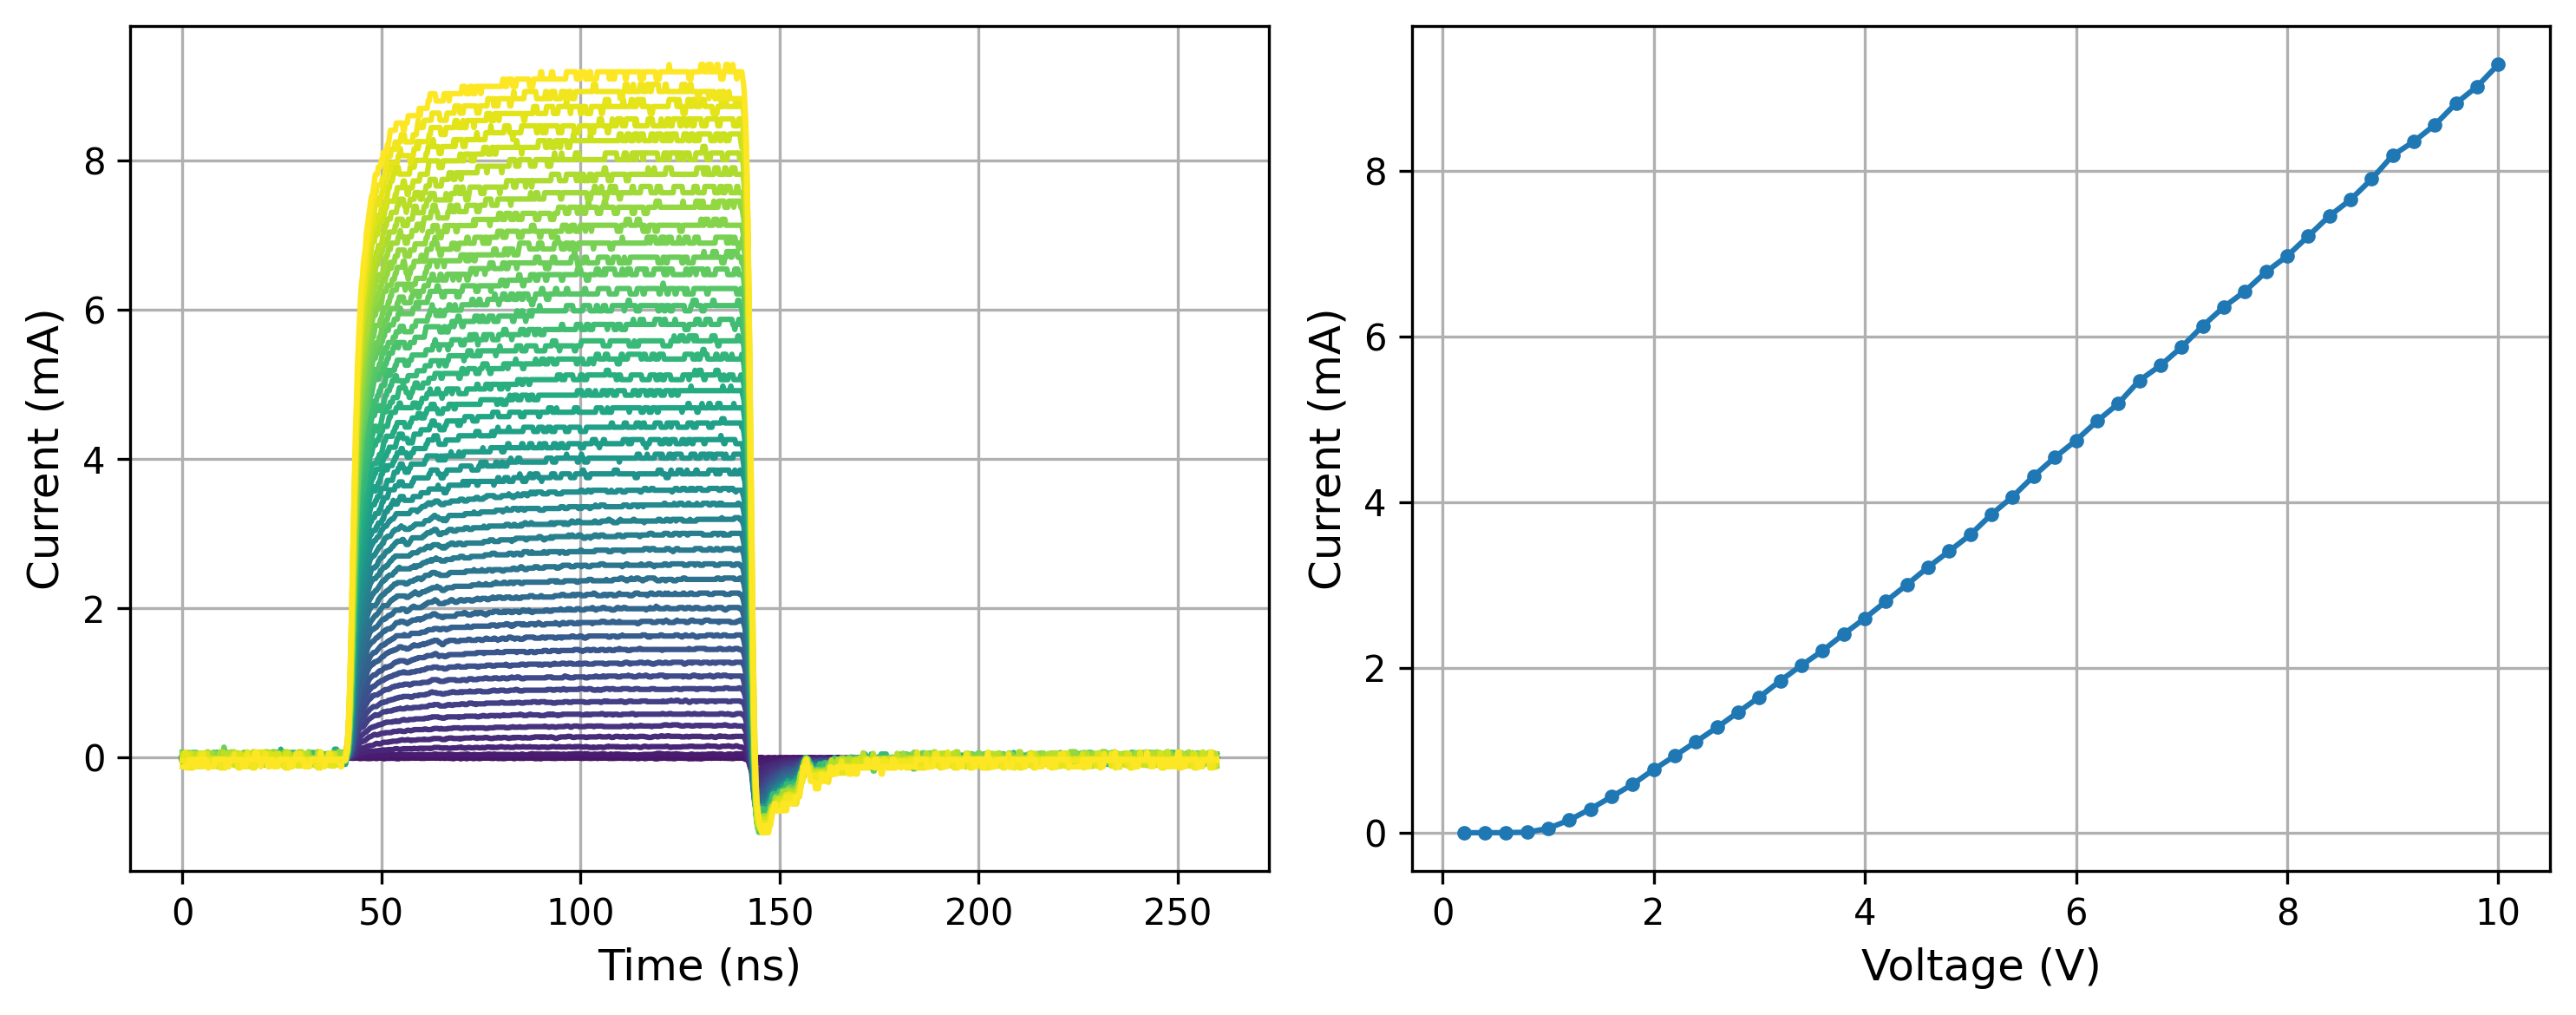

In [54]:
# ===== Figure settings ===============================
fig, axs = plt.subplots(1, 2,figsize=(10, 4), dpi= 300, layout = 'tight')

# ====================================================
# ========= Figure a =================================
# ====================================================
axs[0].set_xlabel('Time (ns)', fontsize=12) 
axs[0].set_ylabel('Current (mA)',fontsize=12)
#axs[0].set_xscale("log"); 
#axs[0].set_ylim([-150, 0])
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].grid()
Current = []
Voltage = []
n = 50
colors = plt.cm.viridis(np.linspace(0, 1, n)) # using color map for plot

for i in range (n):
    data = pd.read_csv('d01_'+str('{:.1f}'.format(0.2*(i+1))+'V.csv'))
    axs[0].plot(data['Time (s)'] * 1e9, data['Voltage (V)']*1000/50, color=colors[i], label=str('{:.1f}'.format(0.2*(i+1))+'V'))
    Imax = np.max(data['Voltage (V)'])*1000/50 #mA
    Current.append(Imax)
    Voltage.append(0.2*(i+1))
    
#axs[0].legend(fontsize="8", loc="best")
print(Current)
print(Voltage)
#plt.savefig('combined.jpg')

# ====================================================
# ========= Figure b =================================
# ====================================================
axs[1].set_xlabel('Voltage (V)', fontsize=12) 
axs[1].set_ylabel('Current (mA)',fontsize=12)
#axs[1].set_xscale("log"); 
#axs[1].set_ylim([-150, 0])
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].grid()

axs[1].plot(Voltage, Current,'.-')
